In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import time
# from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
%matplotlib inline

In [29]:
dams5 = [27, 189, 216, 135, 108,] + [9,36,45,63,90,117,126,144,153,171,198,207,225,234]   ## dams on order_3 and order_4 Note: dams on the links closer to the outlet included (SCENARIO-5)
n_dams5 = len(dams5)

In [68]:
def plot_4paper(link_ids, results, plt_kwargs,d_type='discharge',discharge_axis=None, area=None, save=None, 
            max_storage=None, storage_int=5, fig_size=(20, 6), x_timescale='hour', x_stepsize=5, legend=True, x_hours=120):
    '''Plots simulation results
    
    Parameters:
        links_ids:int or list, link ids for which hydrograph or storage (if a dam exists) to be plotted
        forcing:list, minute-based precipitation data
        results:list, includes pd.DataFrames which are output of hlm_basic
        plt_kwargs:list, includes pyplot kwargs. kwargs dictionaries must follow the order of results
        d_type:'discharge' or 'storage', type of the data
        discharge_axis:(optional) list, to customize discharge axis [min, max, stepsize]
        area:(optional) float, upstream aream of correspoding link,use to show mean annual flood level
        save:(optional) str, save name (with or without full path)
        max_storage:float, draws a line at maximum capacity of a dam
        storage_int:float,  steps for axis ticks when storage is shown
        fig_size:tuple, (x, y) the size of figure
        x_timescale:str, if None, 'minute' else 'hour', 'day'
        x_stepsize;int, the intervals of x ticks
        legend:boolean, shows legend if true   

    '''
    
    rcParams.update({'font.size': 22,'axes.labelweight':'bold','axes.labelsize':22,\
                            'ytick.major.size':6,'xtick.major.size':6,'xtick.direction':'in','ytick.direction':'in',\
                            'lines.linewidth':3.5})
    kwargs = plt_kwargs.copy()
    init_time = np.floor(results[0].index[0])
    if x_timescale=='hour':
        min2newScale = 60
        xlabel = 'Time[hour]'
    elif x_timescale=='day':
        min2newScale = 24*60
        xlabel = 'Time[day]'
    elif x_timescale==None:
        min2newScale = 1
        xlabel = 'Time[min]'


    
    fig, ax = plt.subplots(1, 1, figsize=fig_size)

    x_mins = x_hours*60
    ax.set_xlim([init_time, init_time+x_mins])
    ax.set_xticks(np.arange(init_time, init_time+x_mins, x_stepsize*min2newScale))
    ax.set_xticklabels(np.arange(init_time/(min2newScale), (init_time+x_mins)/(min2newScale), x_stepsize).astype(int))

 
    j=0
    if type(link_ids) != list: link_ids =[link_ids]
    for result in results:
        for link_id in link_ids:
            ax.plot(result.index, result[str(link_id)].values, **kwargs[j])
        j += 1
    if d_type == 'discharge':
        ax.set(xlabel=xlabel, ylabel='Discharge[m$^3$/s]')
        # ax[1].set_xlim([0, len(forcing)])
        # leg_title = 'LINK'
        if discharge_axis is not None:
            start = discharge_axis[0]
            end = discharge_axis[1]
            step = discharge_axis[2]
            ax.set_ylim([start, end])
            ax.set_yticks(np.arange(start, end, step))
        if area is not None:
            maf = round(3.12 * area**0.57 , 2)
            ax.axhline(y=maf, c='r', linestyle='dashed', linewidth=2)
            ax.text(results[0].index[0]+len(forcing)/4, maf, f'Mean Annual Flood = {maf} m$^3$/s', va='bottom', ha='center')

    elif d_type == 'storage':
        ax.set(xlabel=xlabel, ylabel='Storage[10$^3$ m$^3$]')
        # ax[1].set_xlim([0, len(forcing)])
        if max_storage is not None:
            step = len(str(max_storage))-2
            ax.set_ylim([-5, max_storage])
            # ax.axhline(y=max_storage, c='r', linestyle='dashed', linewidth=2)
            ax.set_yticks(np.arange(0,max_storage,storage_int*10**step))
            ax.set_yticklabels(np.arange(0,int((max_storage)/1000), storage_int*10**step/1000).astype(int))

    if legend == True: 
        colors = []
        labels = []
        linestyles = []
        for i in range(len(plt_kwargs)):
            colors.append(plt_kwargs[i]['color'])
            labels.append(plt_kwargs[i]['label'])
            try:
                linestyles.append(plt_kwargs[i]['linestyle'])
            except KeyError:
                linestyles.append('solid')
        lines = [Line2D([0], [0], color=c, linestyle=l) for c, l in zip(colors, linestyles)]
        ax.legend(lines, labels, loc='upper right',framealpha=1, edgecolor='k')

    ax.grid()
    plt.subplots_adjust(hspace=0)
    if save is not None:
        fig.savefig(save + '.png',bbox_inches = 'tight', pad_inches = 0.5)

In [79]:
#passive
name = '125_e6'
dc_nodam = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/dc_nodam_{name}.csv', index_col=['Unnamed: 0'])
dc_passive_S5 = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/dc_passive_{name}.csv', index_col=['Unnamed: 0'])
st_passive_S5 = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/st_passive_{name}.csv', index_col=['Unnamed: 0'])
out_passive_S5 = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/out_passive_{name}.csv', index_col=['Unnamed: 0'])
#random
dc_active_S5r = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/dc_active_Random_{name}.csv', index_col=['Unnamed: 0'])
st_active_S5r = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/st_active_Random_{name}.csv', index_col=['Unnamed: 0'])
out_active_S5r = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/out_active_Random_{name}.csv', index_col=['Unnamed: 0'])
#ga
dc_active_S5g = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/dc_active_GA_{name}.csv', index_col=['Unnamed: 0'])
st_active_S5g = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/st_active_GA_{name}.csv', index_col=['Unnamed: 0'])
out_active_S5g = pd.read_csv(f'/Users/gurbuz/Supp_DamStudy/final_ActiveControl/out_active_GA_{name}.csv', index_col=['Unnamed: 0'])

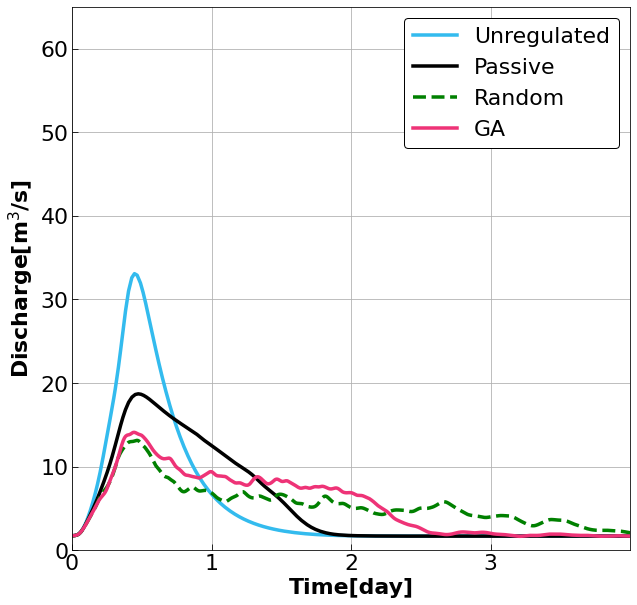

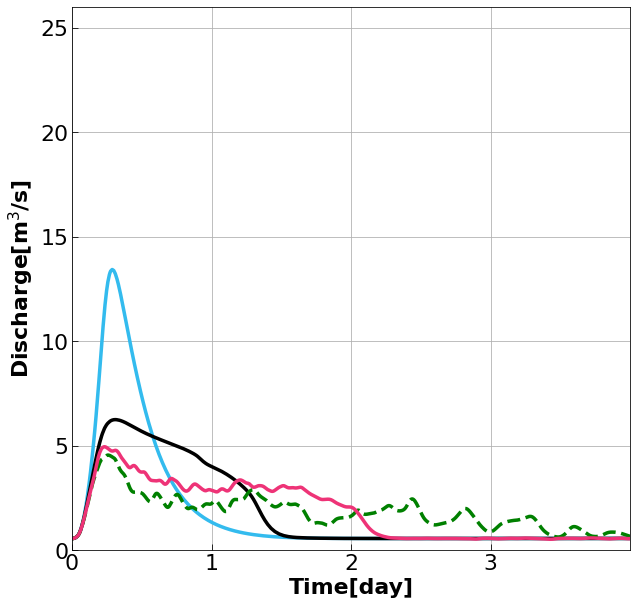

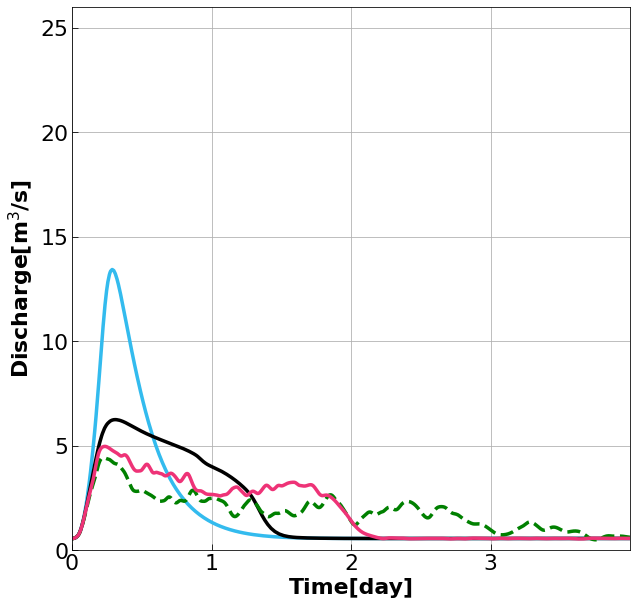

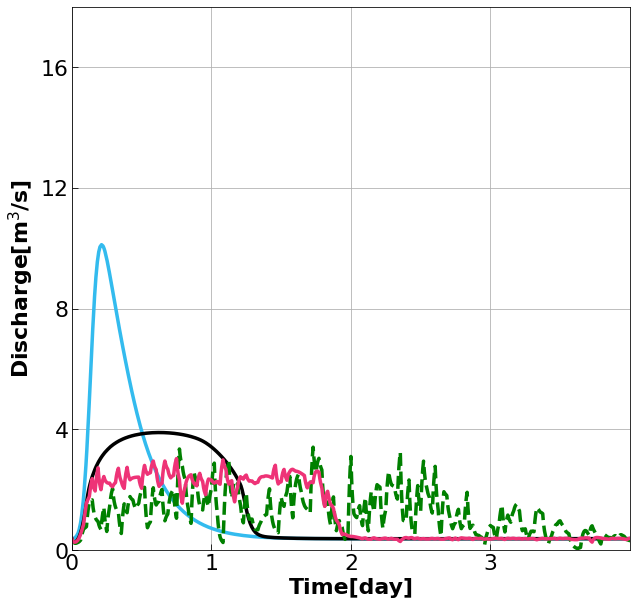

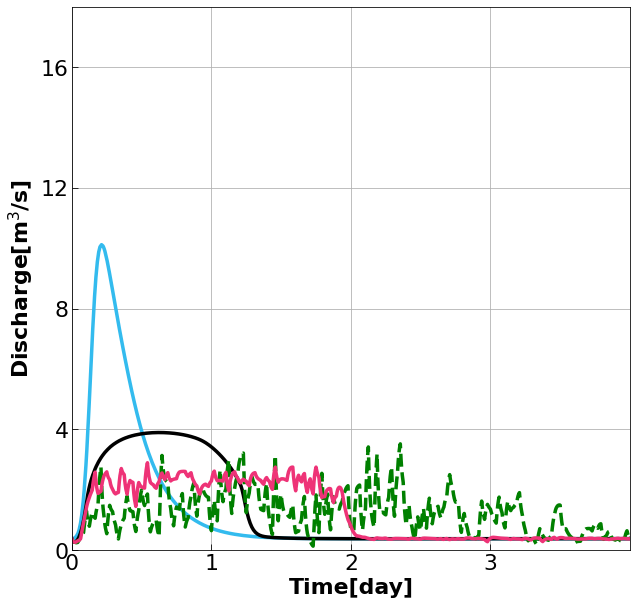

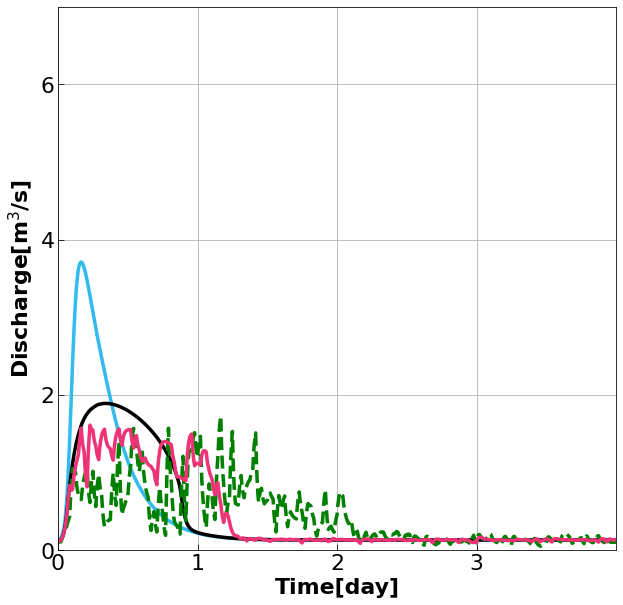

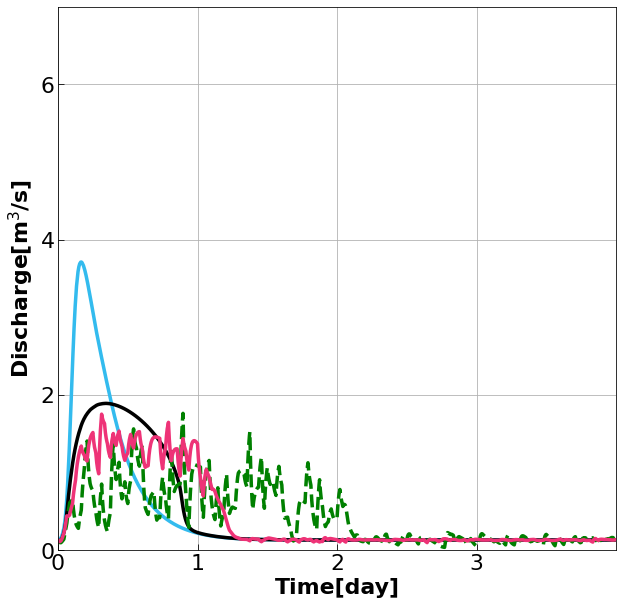

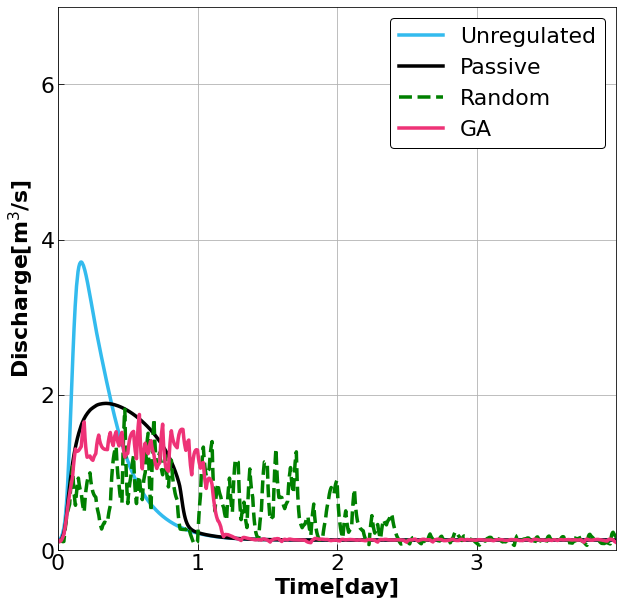

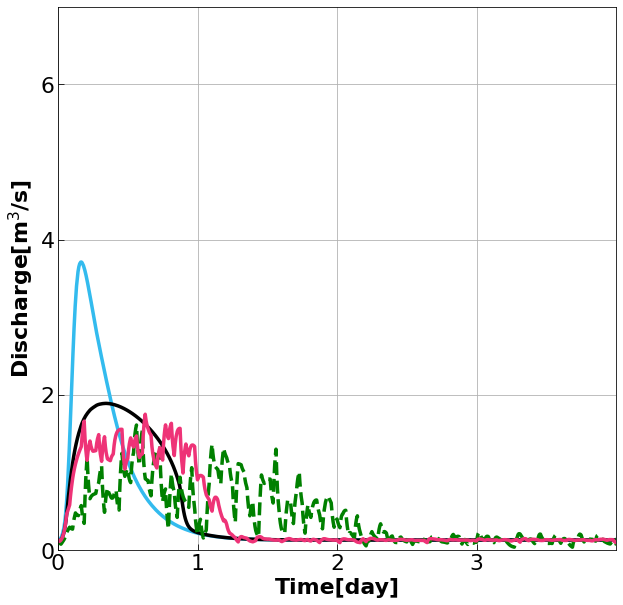

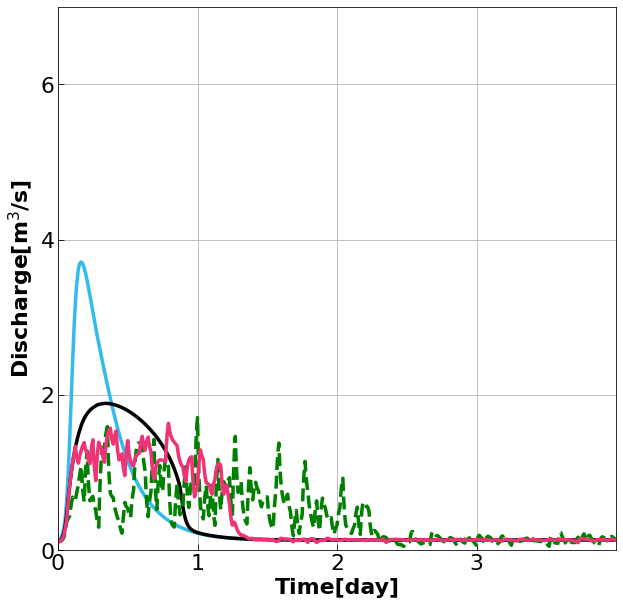

In [80]:
path = f"/Users/gurbuz/Supp_DamStudy/final_ActiveControl/figures/{name}/"
#  np.array([{'label':'Passive', 'color':'k'}, {'label':'Random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'}])
pltkwargs = np.array([{'label':'Unregulated', 'color':'#33bbee'},{'label':'Passive', 'color':'k'}, {'label':'Random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'}])
pltKwargs = pltkwargs[[0,1,2,3]]
dataset = [dc_nodam,dc_passive_S5,dc_active_S5r,dc_active_S5g]

plot_4paper(0,  dataset, pltKwargs, d_type='discharge',discharge_axis=[0,65,10], x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, save=path+'0')
plot_4paper(81,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,26,5],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'81')
plot_4paper(162,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,26,5],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'162')
plot_4paper(188,  dataset, pltKwargs, d_type='discharge',discharge_axis=[0,18,4],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'188')
plot_4paper(107,  dataset, pltKwargs, d_type='discharge',discharge_axis=[0,18,4],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'107')
plot_4paper(35,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,7,2],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'35')
plot_4paper(116,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,7,2],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'116')
plot_4paper(143,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,7,2],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=True, save=path+'143')
plot_4paper(197,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,7,2],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'197')
plot_4paper(224,  dataset, pltKwargs, d_type='discharge', discharge_axis=[0,7,2],x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'224')



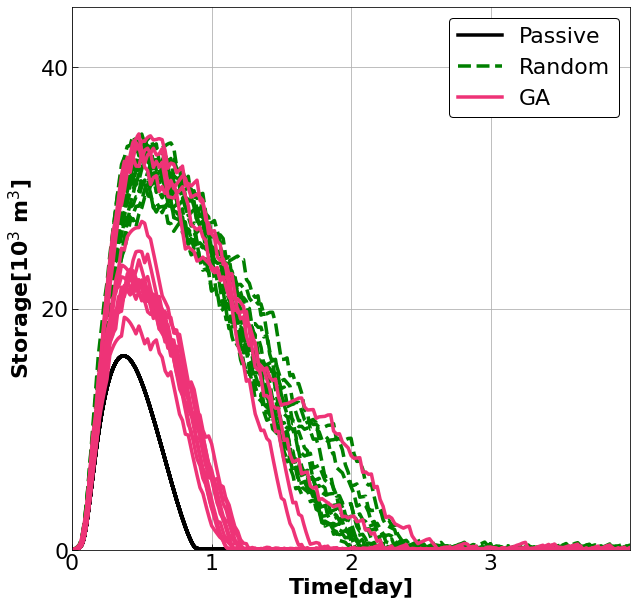

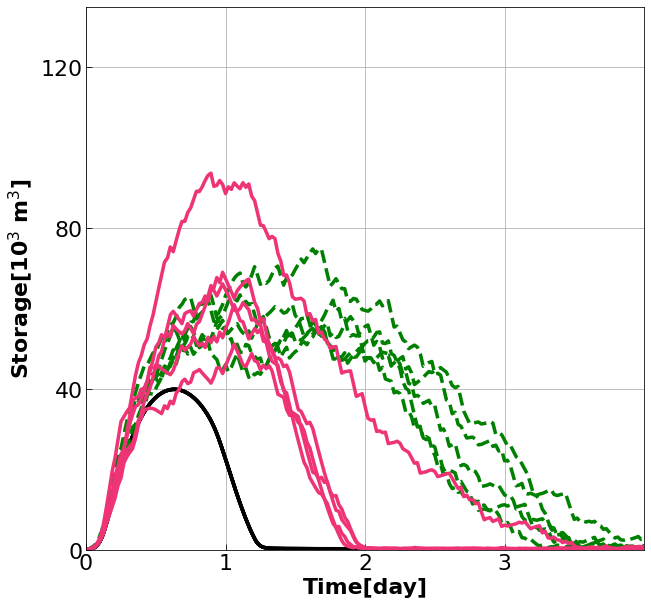

In [81]:
pltKwargs = pltkwargs[[1,2,3]]
dataset = [st_passive_S5,st_active_S5r,st_active_S5g]
plot_4paper(dams5[5:],  dataset, pltKwargs, d_type='storage', max_storage=45000,storage_int=20,x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, save=path+'Order_3')
plot_4paper(dams5[:5],  dataset, pltKwargs, d_type='storage', max_storage=135000,storage_int=4,x_timescale='day',x_stepsize=1,fig_size=(10, 10),x_hours=96, legend=False, save=path+'Order_4')

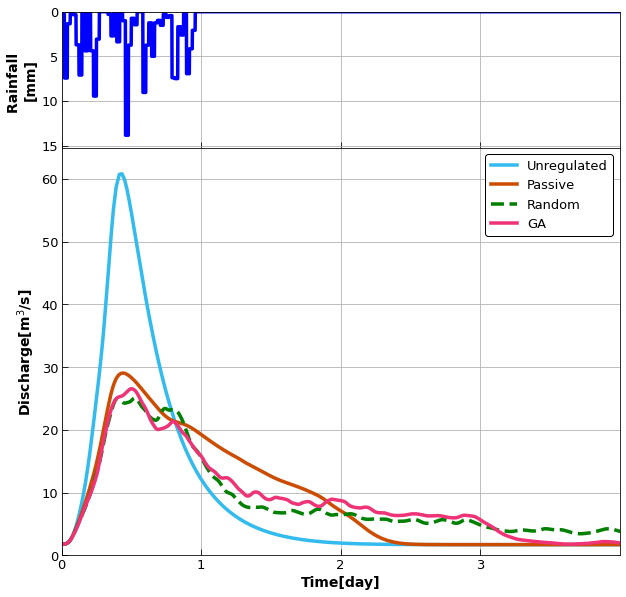

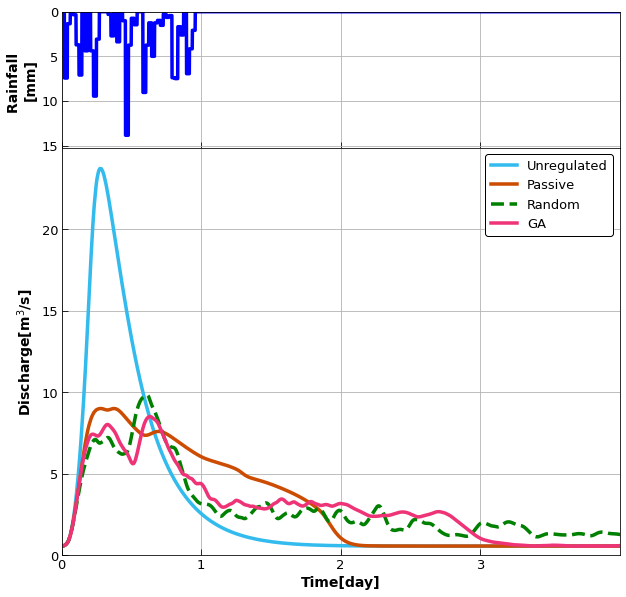

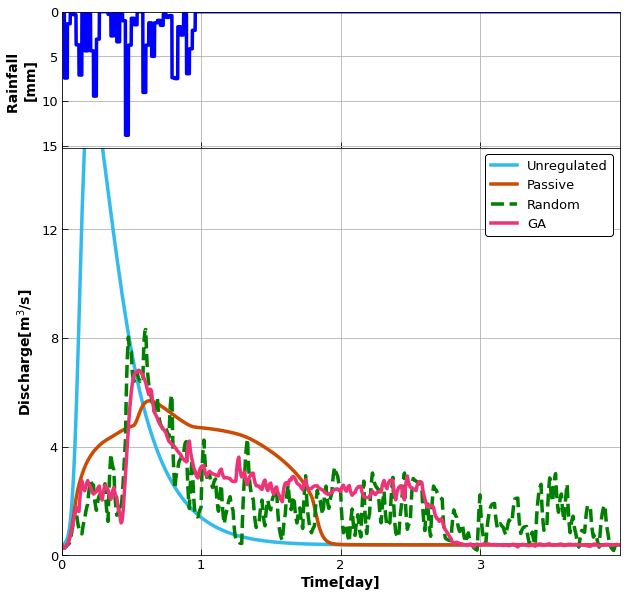

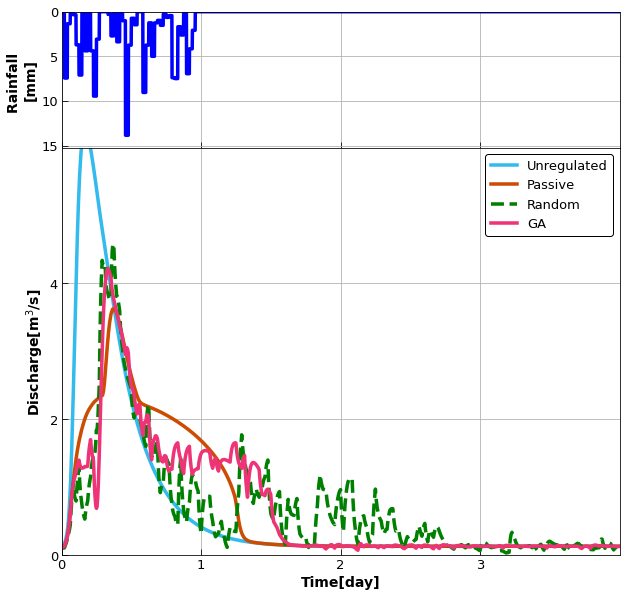

In [16]:
path = "/Users/gurbuz/c:/Users/gurbuz/Desktop/active_new/"
#  np.array([{'label':'Passive', 'color':'k'}, {'label':'Random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'}])
pltkwargs = np.array([{'label':'Unregulated', 'color':'#33bbee'},{'label':'Passive', 'color':'#cc4c02'}, {'label':'Random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'}])
pltKwargs = pltkwargs[[0,1,2,3]]
dataset = [dc_nodam,dc_passive_S5,dc_active_S5r,dc_active_S5g]

plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge',discharge_axis=[0,65,10], x_timescale='day',x_stepsize=1,fig_size=(10, 10),)# save=path+"0_175")
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,25,5],x_timescale='day',x_stepsize=1,fig_size=(10, 10),)# save=path+"81_175")
plot_sim(188, forcing, dataset, pltKwargs, d_type='discharge',discharge_axis=[0,15,4],x_timescale='day',x_stepsize=1,fig_size=(10, 10),)# save=path+"188_175")
# save=path+"35_175")



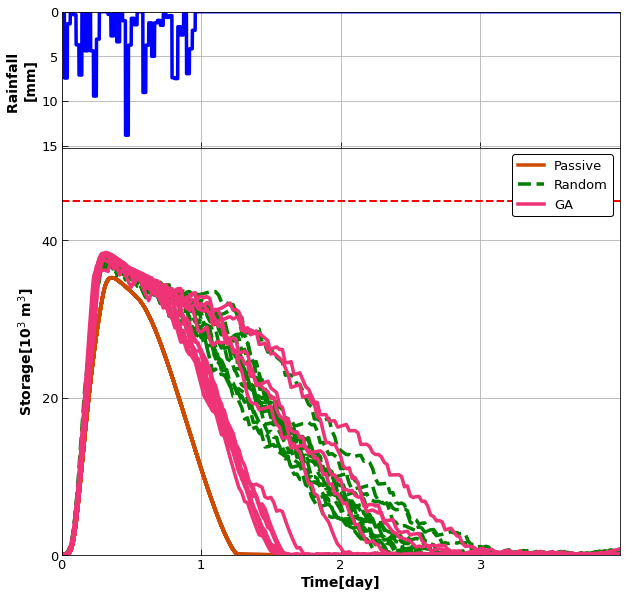

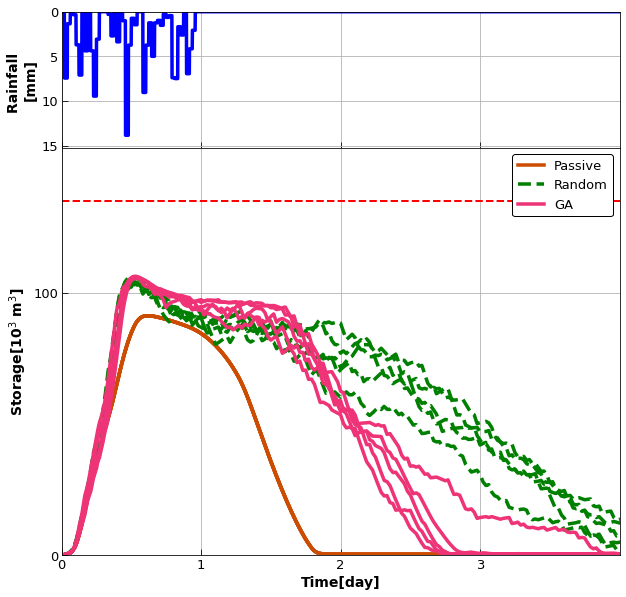

In [15]:
pltKwargs = pltkwargs[[1,2,3]]
dataset = [st_passive_S5,st_active_S5r,st_active_S5g]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams5[5:], forcing, dataset, pltKwargs, d_type='storage', max_storage=45000,storage_int=20,x_timescale='day',x_stepsize=1,fig_size=(10, 10))#,save=path+"O3_175")
plot_sim(dams5[:5], forcing, dataset, pltKwargs, d_type='storage', max_storage=135000,storage_int=10,x_timescale='day',x_stepsize=1,fig_size=(10, 10))#,save=path+"O4_175")

In [ ]:
in_out_Kwargs = np.array([{'label':'passive', 'color':'#1AFF1A'},{'label':'random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'},{'label':'inflow GA', 'color':'cyan'},{'label':'inflow passive', 'color':'gray', 'linestyle':'dashed'} ],)
dataset = [out_passive_S5,out_active_S5r,out_active_S5g, dc_active_S5g, dc_passive_S5]
plot_sim(36, forcing, dataset,in_out_Kwargs[[0,1,2,3,4]], d_type='discharge',discharge_axis=[0,3,1], x_timescale='day',x_stepsize=1,fig_size=(10, 10),save=path+'io36_175_g2')
plot_sim(45, forcing, dataset,in_out_Kwargs[[0,1,2,3,4]], d_type='discharge',discharge_axis=[0,3,1], x_timescale='day',x_stepsize=1,fig_size=(10, 10),save=path+'io45_175_g2')
plot_sim(27, forcing, dataset,in_out_Kwargs[[0,1,2,3,4]], d_type='discharge',discharge_axis=[0,5,2], x_timescale='day',x_stepsize=1,fig_size=(10, 10),save=path+'io27_175_g2')




In [130]:
#passive
dc_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_passive_S5_175.csv', index_col=['Unnamed: 0'])
st_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_passive_S5_175.csv', index_col=['Unnamed: 0'])
out_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_passive_S5_175.csv', index_col=['Unnamed: 0'])
#random
dc_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_active_S5r_175.csv', index_col=['Unnamed: 0'])
st_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_active_S5r_175.csv', index_col=['Unnamed: 0'])
out_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_active_S5r_175.csv', index_col=['Unnamed: 0'])
#ga
dc_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_active_S5g_175.csv', index_col=['Unnamed: 0'])
st_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_active_S5g_175.csv', index_col=['Unnamed: 0'])
out_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_active_S5g_175.csv', index_col=['Unnamed: 0'])

Model 256 (254 with_dams) is being used!
No dam is set!
INFO: No dam is set!
No dam is set!


In [62]:
SSN1 = Watershed(Model=256)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN1.dam_ids = dams5
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams5)
dam_params256 = SSN1.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
S = [50 for _ in range(len(dams5))]
SSN1.set_dam_state(states=[1 for _ in range(len(dams5))])
SSN1.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S5, st_passive_S5 = SSN1.Run_256( [0, te], forcing, dam_params256)
out_passive_S5 = SSN1.CalculateOutflow(dam_params256, st_passive_S5)

Model 256 (254 with_dams) is being used!


In [74]:
#passive
dc_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_passive_S5_125.csv', index_col=['Unnamed: 0'])
st_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_passive_S5_125.csv', index_col=['Unnamed: 0'])
out_passive_S5 = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_passive_S5_125.csv', index_col=['Unnamed: 0'])
#random
dc_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_active_S5r_125.csv', index_col=['Unnamed: 0'])
st_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_active_S5r_125.csv', index_col=['Unnamed: 0'])
out_active_S5r = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_active_S5r_125.csv', index_col=['Unnamed: 0'])
#ga
dc_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/dc_active_S5g_125.csv', index_col=['Unnamed: 0'])
st_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/st_active_S5g_125.csv', index_col=['Unnamed: 0'])
out_active_S5g = pd.read_csv('/Users/gurbuz/Supp_DamStudy/activecontrol/out_active_S5g_125a.csv', index_col=['Unnamed: 0'])

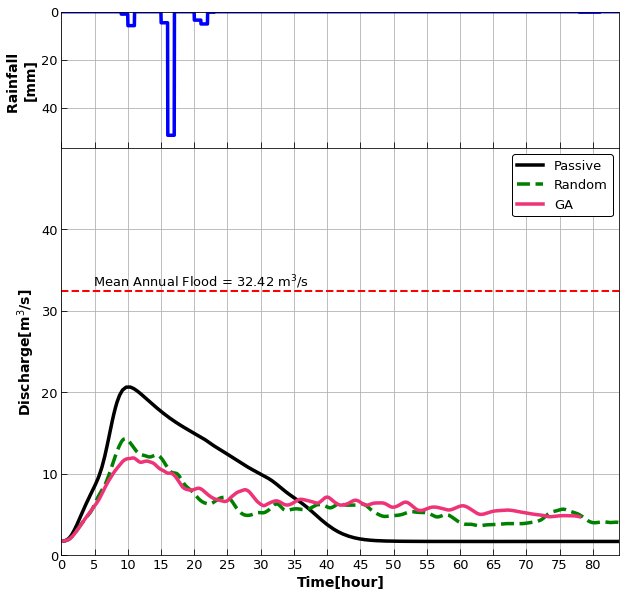

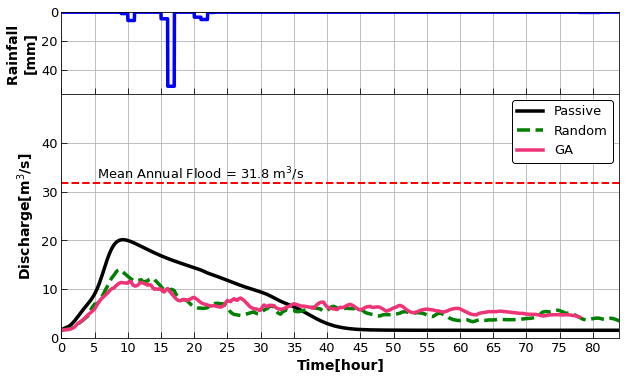

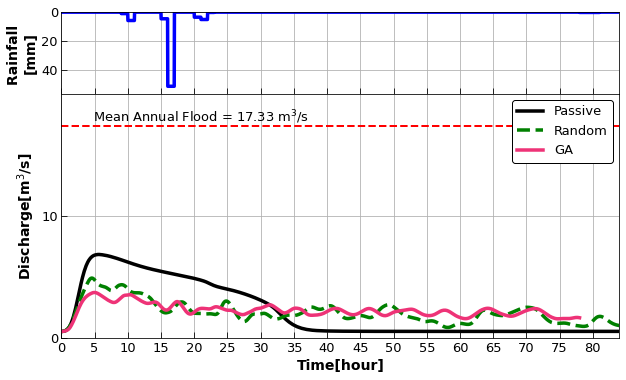

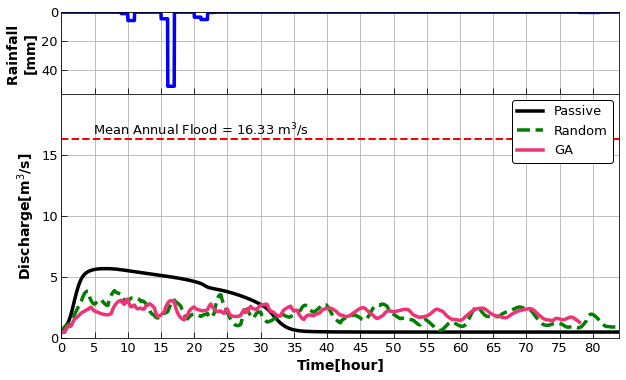

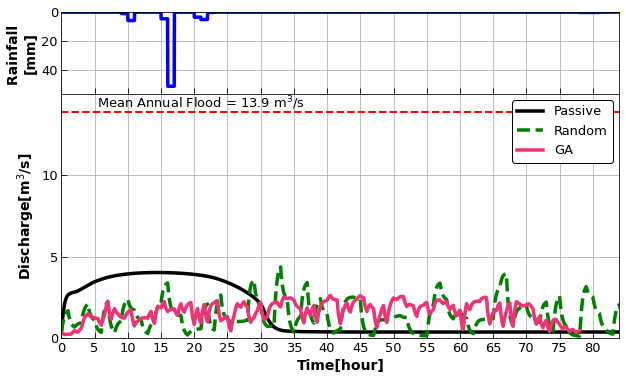

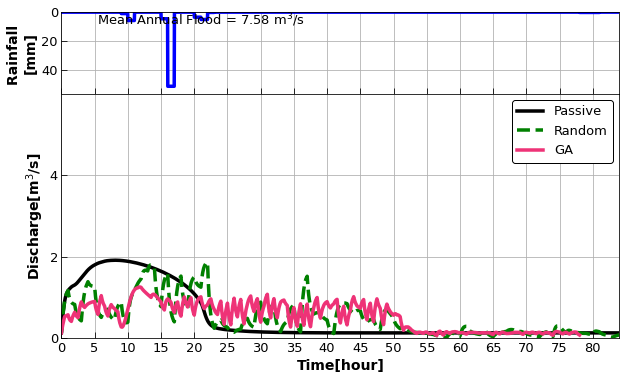

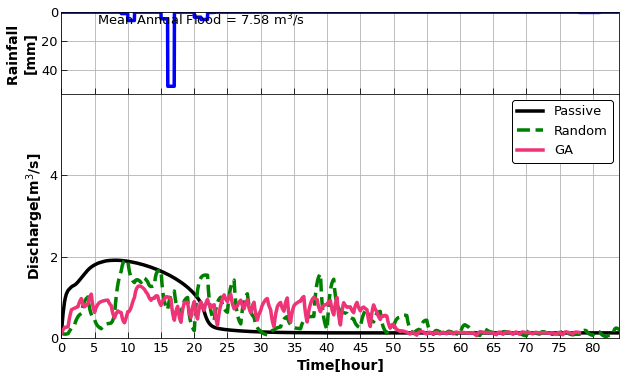

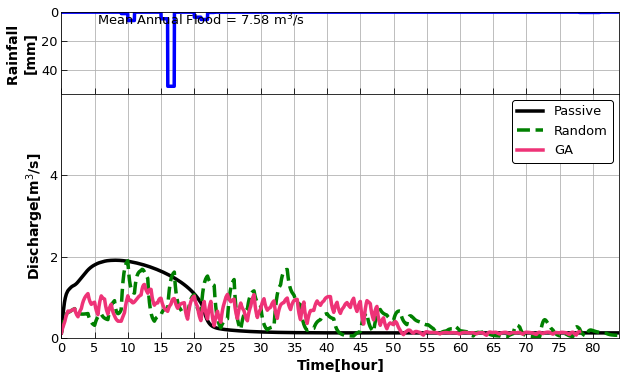

In [75]:
pltkwargs = np.array([{'label':'Passive', 'color':'k'}, {'label':'Random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'}])

pltKwargs = pltkwargs[[0,1,2]]
dataset = [dc_passive_S5,dc_active_S5r,dc_active_S5g]
# plot_sim([0,162, 188], forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,220,20], fig_size=(10, 6))
plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', area=60.75,discharge_axis=[0,50,10],fig_size=(10, 10))
plot_sim(8, forcing, dataset, pltKwargs, d_type='discharge',area=58.75, discharge_axis=[0,50,10],fig_size=(10, 6))
plot_sim(81, forcing, dataset, pltKwargs, d_type='discharge',area=20.25, discharge_axis=[0,20,10],fig_size=(10, 6))
plot_sim(89, forcing, dataset, pltKwargs, d_type='discharge',area=18.25, discharge_axis=[0,20,5],fig_size=(10, 6))
plot_sim(188, forcing, dataset, pltKwargs, d_type='discharge',area=13.75, discharge_axis=[0,15,5],fig_size=(10, 6))
plot_sim(35, forcing, dataset, pltKwargs, d_type='discharge', area=4.75, discharge_axis=[0,6,2],fig_size=(10, 6))
plot_sim(197, forcing, dataset, pltKwargs, d_type='discharge',area=4.75, discharge_axis=[0,6,2],fig_size=(10, 6))
plot_sim(224, forcing, dataset, pltKwargs, d_type='discharge',area=4.75, discharge_axis=[0,6,2],fig_size=(10, 6))


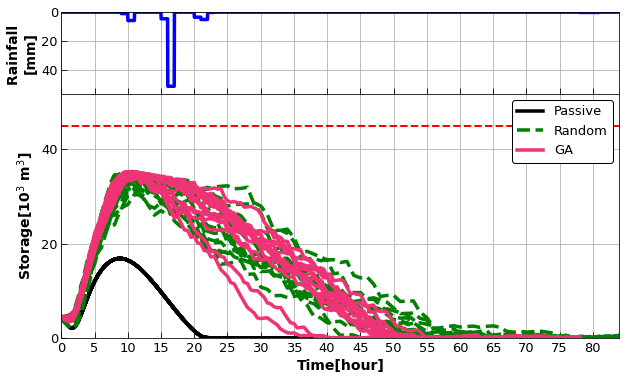

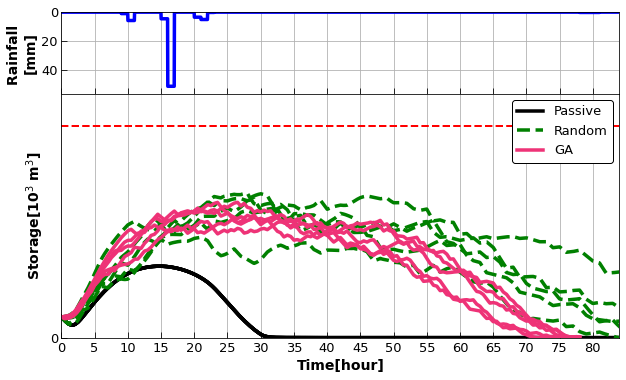

In [76]:
pltKwargs = pltkwargs[[0,1,2]]
dataset = [st_passive_S5,st_active_S5r,st_active_S5g]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams5[5:], forcing, dataset, pltKwargs, d_type='storage', max_storage=45000,storage_int=20,fig_size=(10, 6))
plot_sim(dams5[:5], forcing, dataset, pltKwargs, d_type='storage', max_storage=135000,storage_int=20,fig_size=(10, 6))


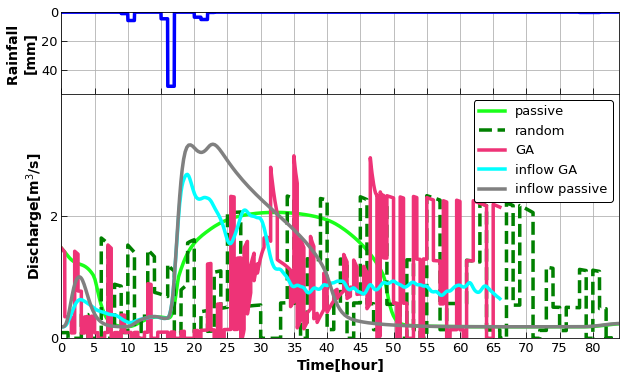

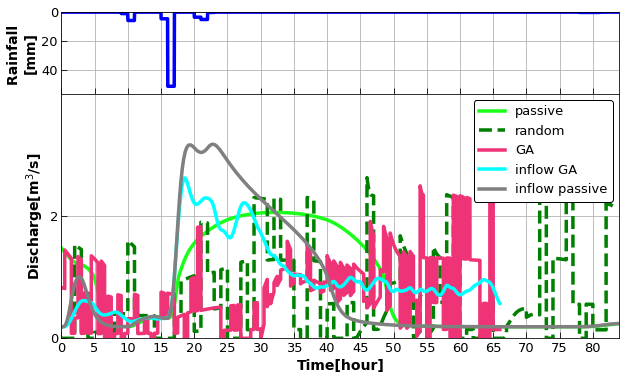

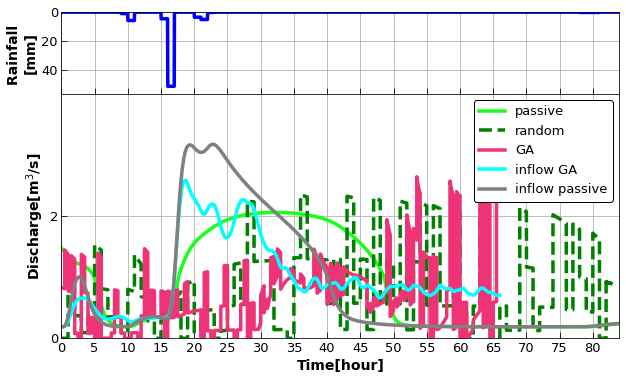

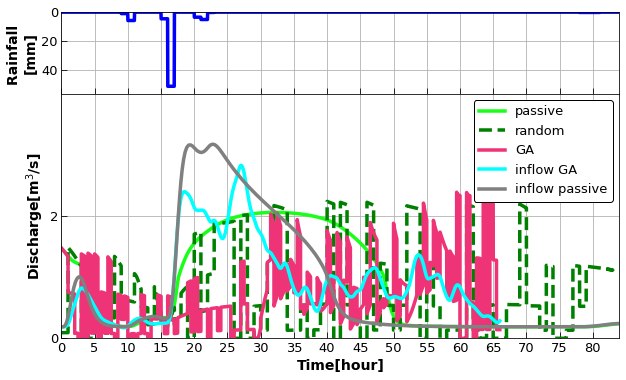

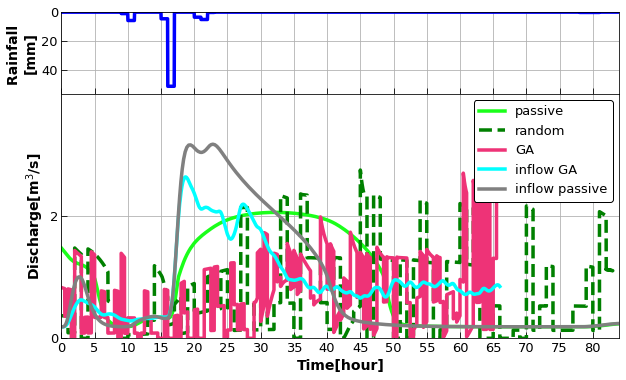

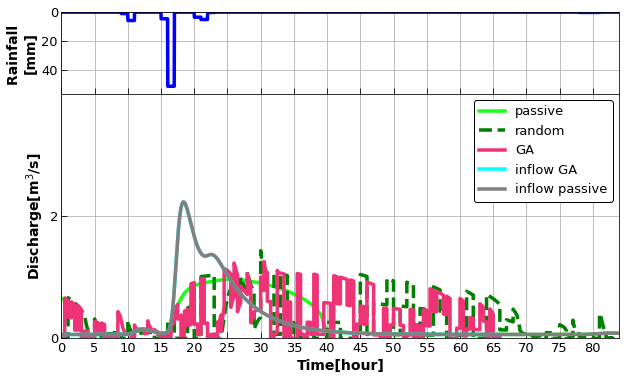

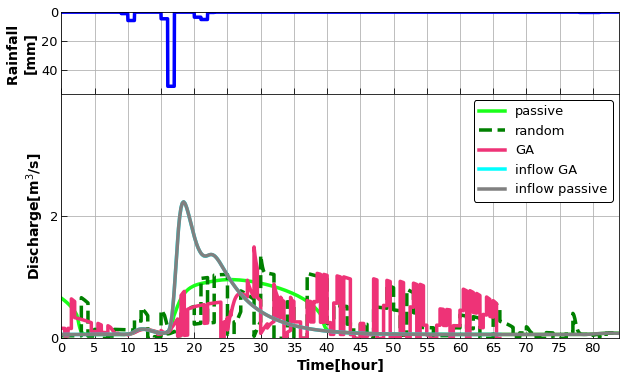

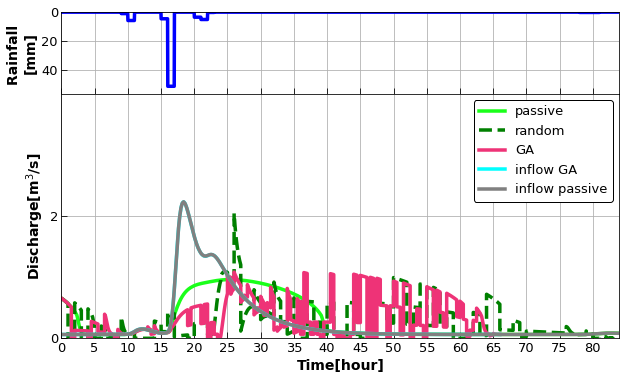

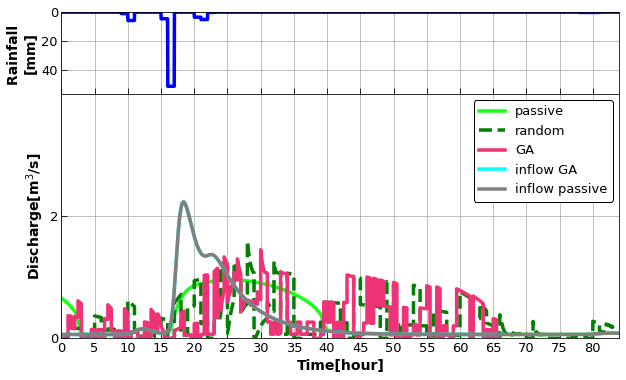

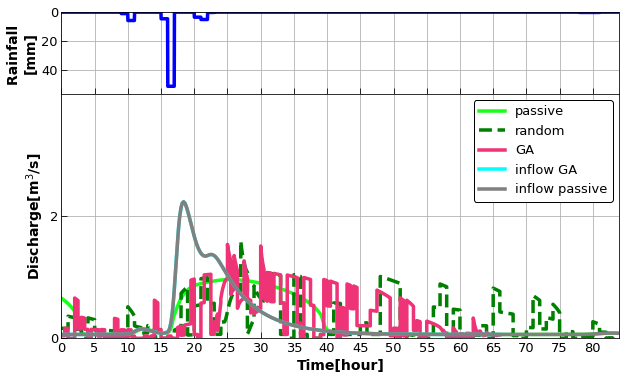

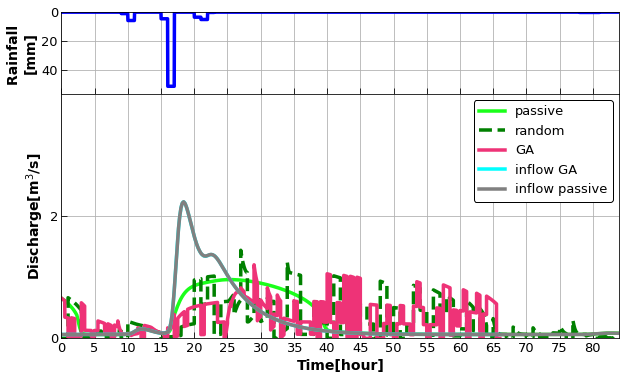

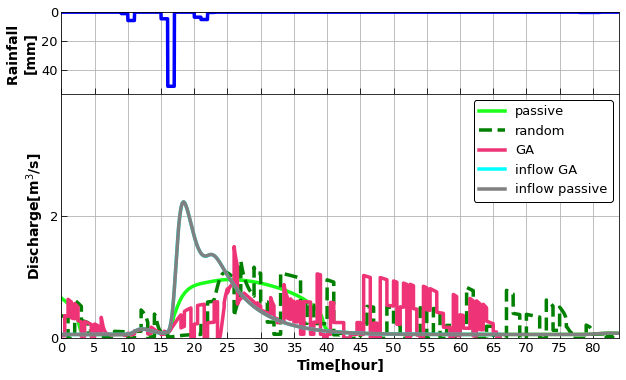

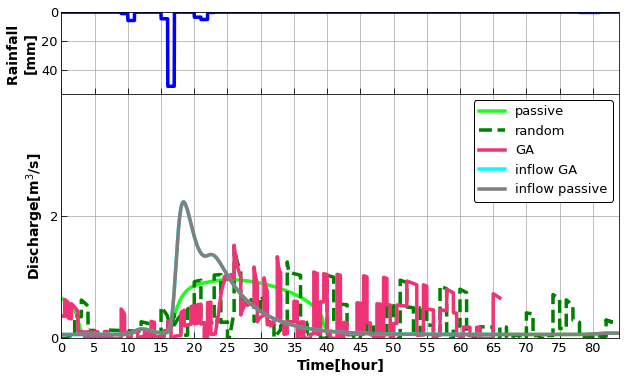

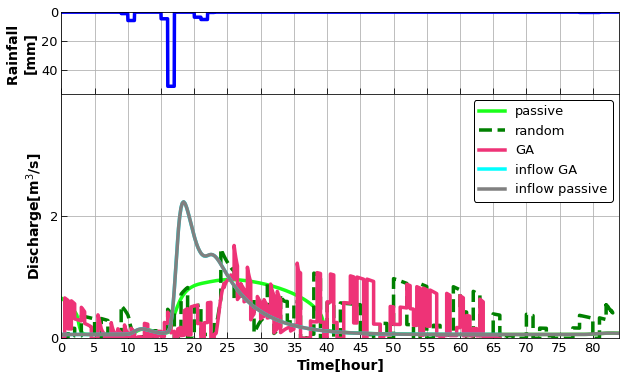

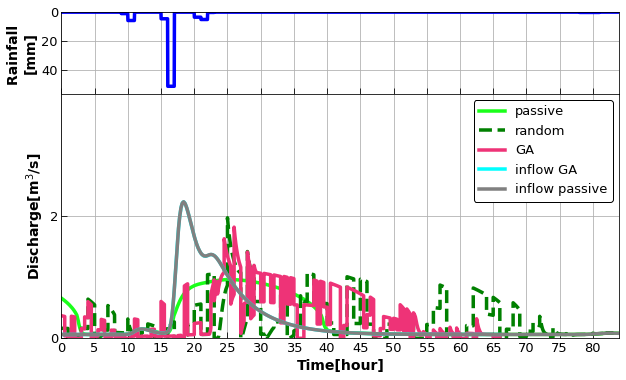

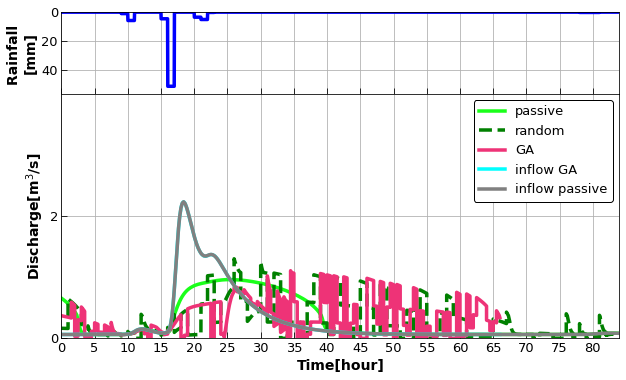

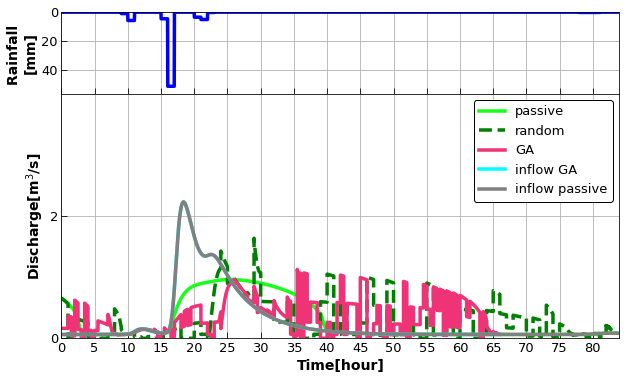

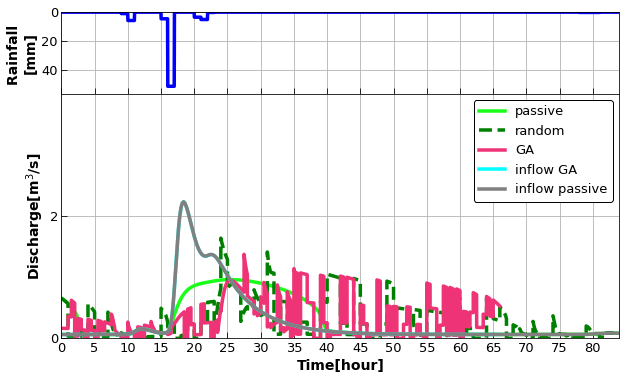

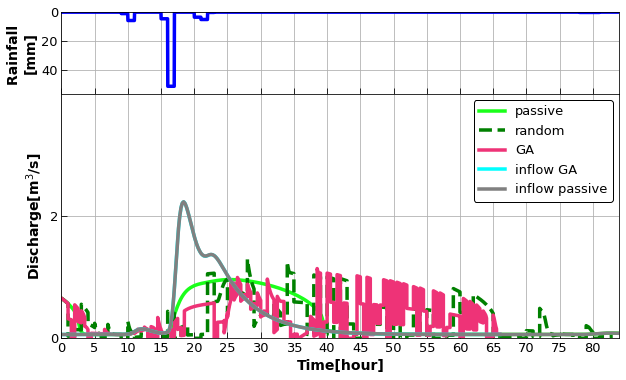

In [72]:
in_out_Kwargs = np.array([{'label':'passive', 'color':'#1AFF1A'},{'label':'random', 'color':'green','linestyle':'dashed'},{'label':'GA', 'color':'#ee3377'},{'label':'inflow GA', 'color':'cyan'},{'label':'inflow passive', 'color':'gray'} ],)

dataset = [out_passive_S5,out_active_S5r,out_active_S5g, dc_active_S5g, dc_passive_S5]
for dam in dams5:
    plot_sim(dam, forcing, dataset, in_out_Kwargs[[0,1,2,3,4]], d_type='discharge', discharge_axis=[0,4,2],fig_size=(10, 6))
    # plot_sim(dams5[1], forcing, dataset, in_out_Kwargs[[0,1,2]], d_type='discharge', discharge_axis=[0,20,5],fig_size=(10, 6))



In [39]:
# def Reward(x, y, flow_norm=1, storage_norm=1, a=1, b=1):
#     return 10*np.exp(-a*(x/flow_norm)**2 - b*(y/storage_norm)**2)
def Reward(x, y, flow_norm=1, storage_norm=1, a=1, b=1):
    return 10*np.exp(-a*(x/flow_norm)**2 - b*(y/storage_norm)**2)

x = np.linspace(-0,1, 10)
y = np.linspace(-0, 1, 10)

X, Y = np.meshgrid(x, y,)
Z = Reward(X, Y, a=10)



Text(0.5, 0, 'Reward')

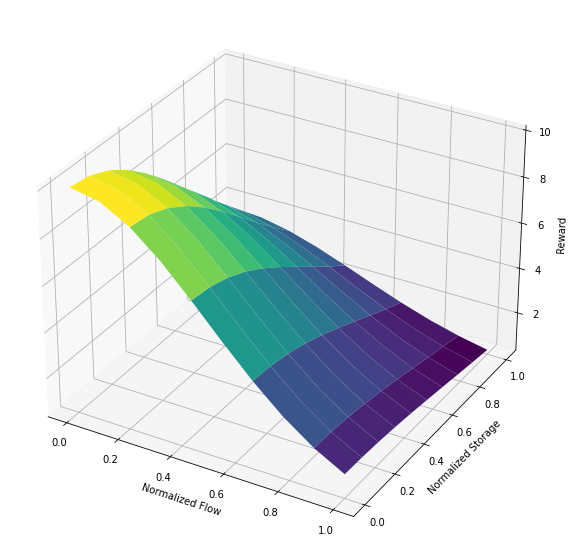

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=2,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Normalized Flow')
ax.set_ylabel('Normalized Storage')
ax.set_zlabel('Reward')
# ax.set_xlim([0,30])
# ax.set_ylim([0, 30])
# ax.set_ylim([2,0])
# ax.set_zlim([0, 1])

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=2,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Normalized Flow')
ax.set_ylabel('Normalized Storage')
ax.set_zlabel('Reward')


NameError: name 'X' is not defined

In [12]:
ref = np.array([0.75, 1.0, 0.5, 1.0, 0.75, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.25, 0.75, 1.0])/0.25
ref

array([3., 4., 2., 4., 3., 3., 2., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.,
       3., 4.])

In [11]:
statein =np.array([0.5, 0.5, 0.25, 1.0, 1.0, 0.5, 0.25, 1.0, 0.75, 1.0, 0.75, 1.0, 0.75, 1.0, 0.75, 1.0, 0.25, 0.5, 1.0])/0.25
statein

array([2., 2., 1., 4., 4., 2., 1., 4., 3., 4., 3., 4., 3., 4., 3., 4., 1.,
       2., 4.])

In [16]:
 np.abs(statein-ref) -1

array([ 0.,  1.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,  0., -1.,  0.,
       -1.,  0.,  0., -1.,  0., -1.])

In [16]:
import bitstring
f1 = bitstring.BitArray(float=0.3, length=32)
print(f1.bin)

00111110100110011001100110011010


In [77]:
def Quad_Params2(threshold, reward):
    '''Parameters of a concave quadratic equation 
    -c is the reward corresponding to the mean annual flow.
    eq: ax2 + bx + c
    returns the parameters a, b, c 
    '''
    a = -8 * reward / threshold ** 2
    b = 8 * reward / threshold
    c = -reward
    return a, b, c
a, b, c = Quad_Params2(10, 10)

[]

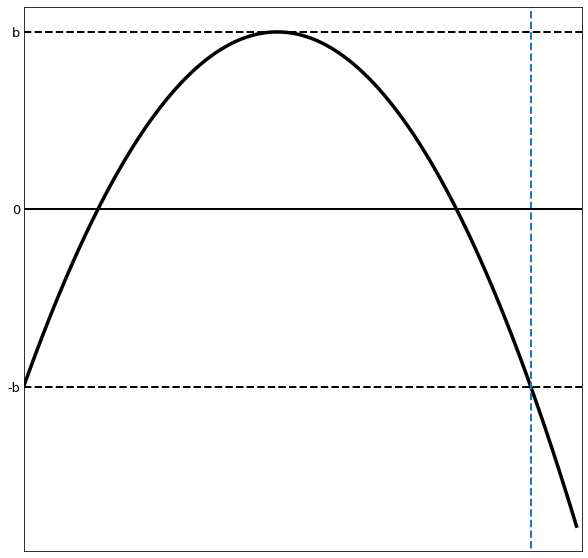

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(0, 11, 0.1), a*np.arange(0, 11, .1)**2+b*np.arange(0, 11, .1)+c, c='k')
ax.axvline(x=10,ymin=-10, ymax=10,linestyle='dashed', linewidth=2)
ax.axhline(y=10, c='k',linestyle='dashed', linewidth=2)
ax.axhline(y=-10, c='k',linestyle='dashed', linewidth=2)
ax.axhline(y=0, c='k', linestyle='solid', linewidth=2)
ax.set_xlim([0, 11])
ax.set_yticks([-10, 0, 10])
ax.set_yticklabels(['-b', '0', 'b'])
ax.set_xticks([])

